In [ ]:
#%%

import quantstats        as qs
import yfinance          as yf
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import talib             as ta

pd.options.mode.copy_on_write = True

In [ ]:
#%%

SYMBOL = "SPY"

df_ = yf.download(SYMBOL, start="1992-01-01", interval="1d", actions=True, auto_adjust=True)
df_

[*********************100%***********************]  1 of 1 completed


Price,Capital Gains,Close,Dividends,High,Low,Open,Stock Splits,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,,,
1993-01-29,0.0,24.526083,0.0,24.543527,24.421420,24.543527,0.0,1003200
1993-02-01,0.0,24.700516,0.0,24.700516,24.543521,24.543521,0.0,480500
1993-02-02,0.0,24.752844,0.0,24.770288,24.630737,24.683068,0.0,201300
1993-02-03,0.0,25.014511,0.0,25.031955,24.770297,24.787741,0.0,529400
1993-02-04,0.0,25.119165,0.0,25.171497,24.822620,25.101722,0.0,531500
...,...,...,...,...,...,...,...,...
2025-02-10,0.0,604.849976,0.0,605.500000,602.739990,604.030029,0.0,26048700
2025-02-11,0.0,605.309998,0.0,605.859985,602.429993,602.549988,0.0,30056700


In [ ]:
#%%

df = pd.DataFrame(index=df_.index)
df['Open'  ] = df_[('Open'  , SYMBOL)]
df['High'  ] = df_[('High'  , SYMBOL)]
df['Low'   ] = df_[('Low'   , SYMBOL)]
df['Close' ] = df_[('Close' , SYMBOL)]
df['Volume'] = df_[('Volume', SYMBOL)]

df['Open'  ] = df['Open' ].round(4)
df['High'  ] = df['High' ].round(4)
df['Low'   ] = df['Low'  ].round(4)
df['Close' ] = df['Close'].round(4)

df

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,24.5435,24.5435,24.4214,24.5261,1003200
1993-02-01,24.5435,24.7005,24.5435,24.7005,480500
1993-02-02,24.6831,24.7703,24.6307,24.7528,201300
1993-02-03,24.7877,25.0320,24.7703,25.0145,529400
1993-02-04,25.1017,25.1715,24.8226,25.1192,531500
...,...,...,...,...,...
2025-02-10,604.0300,605.5000,602.7400,604.8500,26048700
2025-02-11,602.5500,605.8600,602.4300,605.3100,30056700
2025-02-12,599.2000,604.5500,598.5100,603.3600,45076100


In [ ]:
#%%

def strat_ma_cross(df, p_ma_fast, p_ma_slow):
    c                = df['Close'  ]
    df['MA_FAST']    = ta.SMA(df['Close'], timeperiod=p_ma_fast)
    df['MA_SLOW']    = ta.SMA(df['Close'], timeperiod=p_ma_slow)
    ma_fasts         = df['MA_FAST']
    ma_slows         = df['MA_SLOW']
    position         = 0              
    entry_fill_price = 0
    rets             = []
    dates            = []
    unrealized_rets  = []
    unrealized_dates = []
    for i, date in enumerate(c.index):
        if i<p_ma_slow+1: continue
        unrealized_rets .append(((c.iloc[i]-c.iloc[i-1])/c.iloc[i-1])*position)
        unrealized_dates.append(date)
        if  position == 0 and \
            ma_fasts.iloc[i-1] <= ma_slows.iloc[i-1] and \
            ma_fasts.iloc[i  ] >  ma_slows.iloc[i  ]:
            position = 1
            entry_fill_price = c.iloc[i]
        if position == 1 and \
            ma_fasts.iloc[i-1] >= ma_slows.iloc[i-1] and \
            ma_fasts.iloc[i  ] <  ma_slows.iloc[i  ]:
            position = 0
            rets .append((c.iloc[i]-entry_fill_price)/entry_fill_price)
            dates.append(date)
    return dates, rets, unrealized_dates, unrealized_rets

<Axes: >

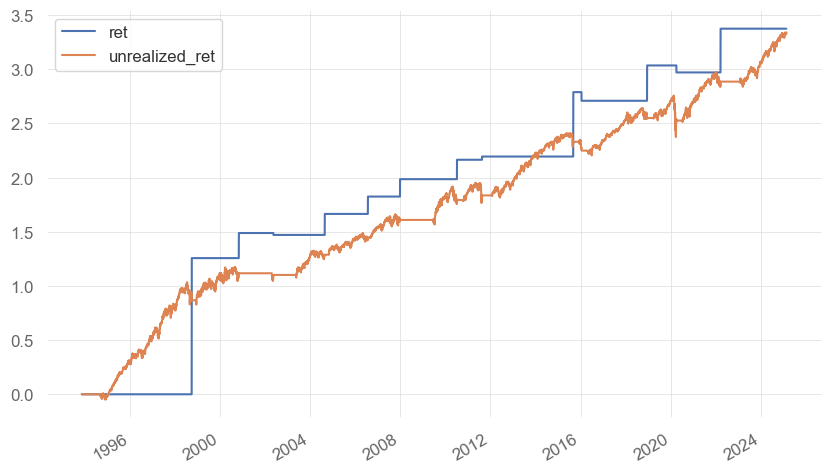

In [ ]:
#%%

MA_FAST = 50
MA_SLOW = 200

dates, rets, unrealized_dates, unrealized_rets = strat_ma_cross(df, p_ma_fast=MA_FAST, p_ma_slow=MA_SLOW)

report_df = pd.DataFrame(index=pd.DatetimeIndex(pd.to_datetime(unrealized_dates)))
report_df['unrealized_ret'] = unrealized_rets
temp_df = pd.DataFrame(index=pd.DatetimeIndex(pd.to_datetime(dates)))
temp_df  ['ret'] = rets
report_df['ret'] = temp_df['ret']
report_df.fillna(0.0, inplace=True)

report_df[['ret', 'unrealized_ret']].cumsum().plot()

In [ ]:
#%%

average_return = float(np.mean(rets))
print(f"Average returns = {average_return}")

Average returns = 0.2595600158893948


<Axes: >

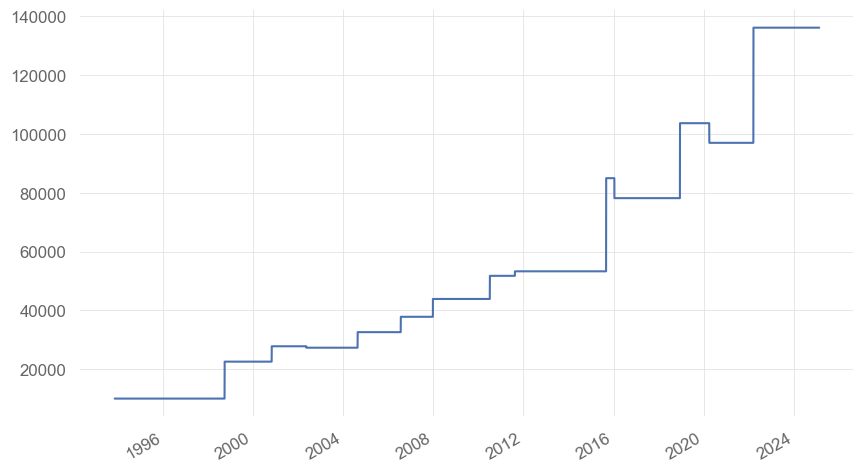

In [ ]:
#%%

# Tracking capital based on order

initial_capital = 10000.0

report_df['GrowthFactor'] = (1 + report_df['ret']).cumprod()
report_df['Equity'      ] = initial_capital*report_df['GrowthFactor']

report_df['Equity'].plot()

In [ ]:
#%%

print(f"Initial equity : {initial_capital}")
print(f"Final equity   : {round(report_df.iloc[-1]['Equity'], 2)}")

Initial equity : 10000.0
Final equity   : 136176.03


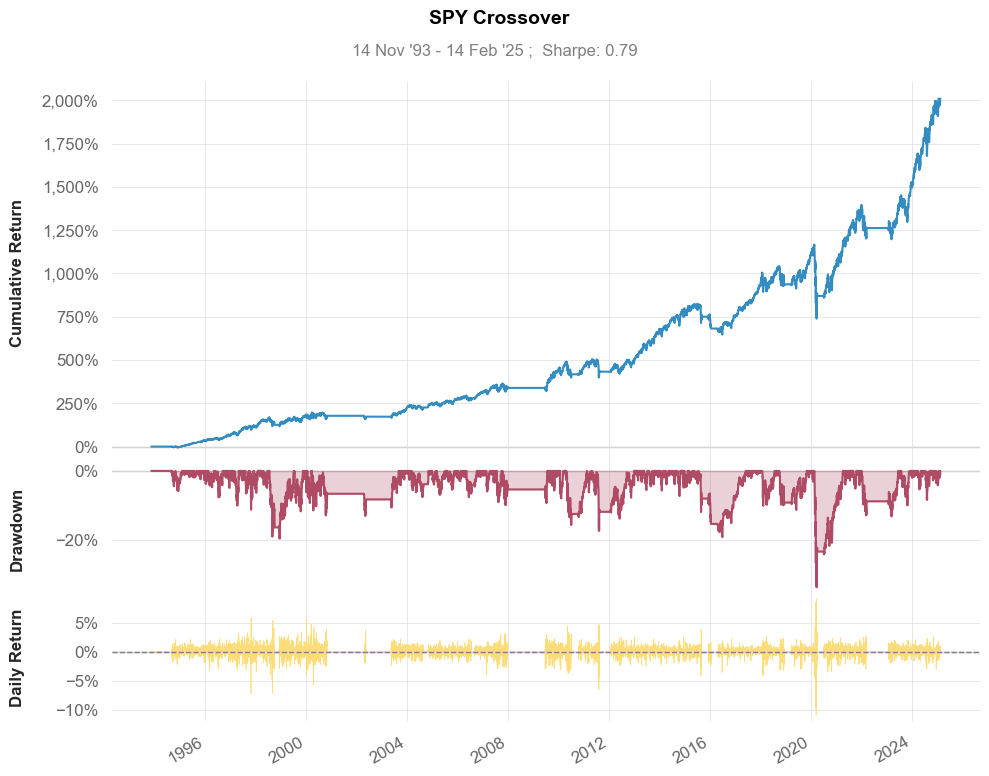

In [ ]:
#%%

qs.plots.snapshot(report_df['unrealized_ret'], title='SPY Crossover', show=True);

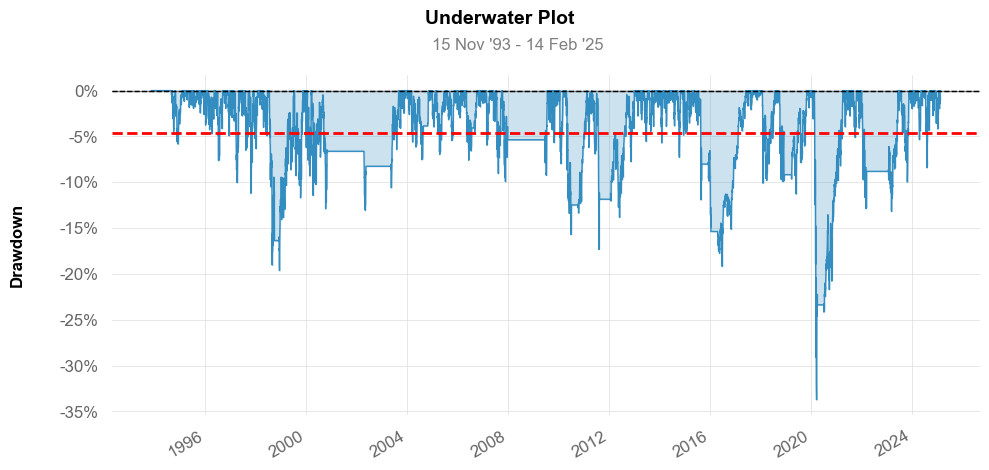

In [ ]:
#%%

qs.plots.drawdown(report_df['unrealized_ret'])

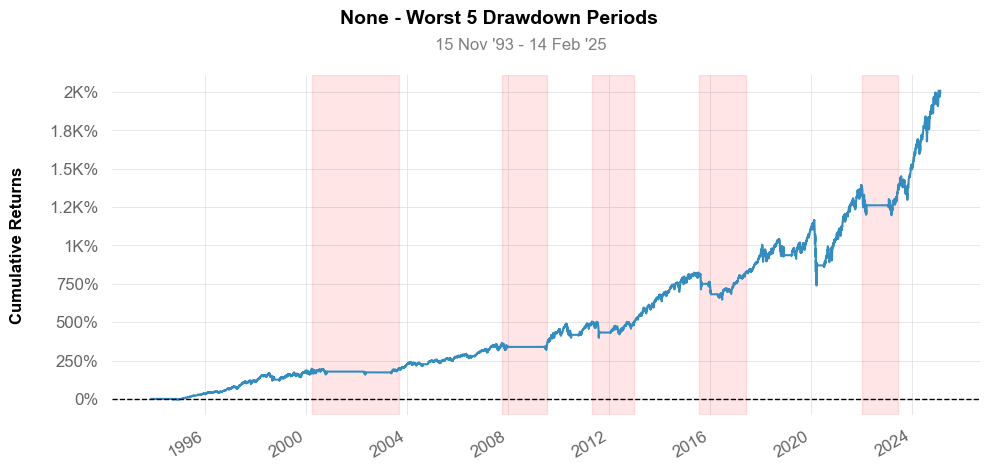

In [ ]:
#%%

qs.plots.drawdowns_periods(report_df['unrealized_ret'])

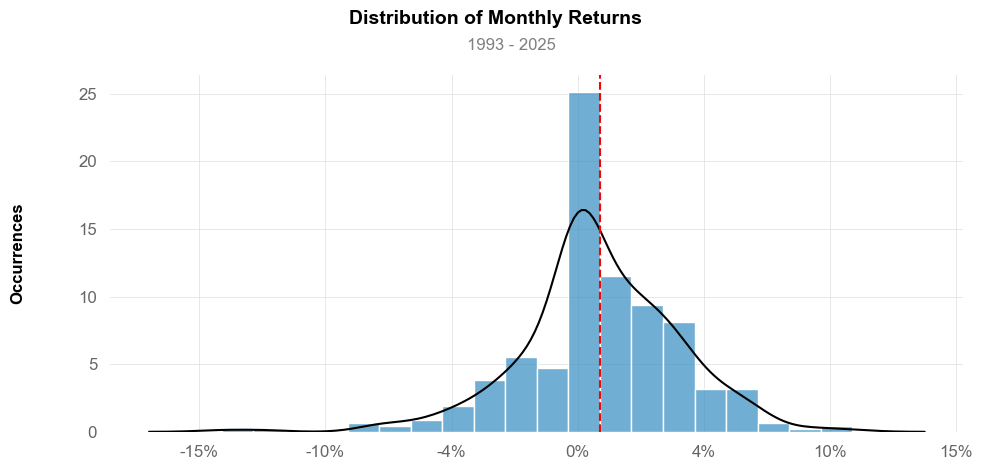

In [ ]:
#%%

qs.plots.histogram(report_df['unrealized_ret'])

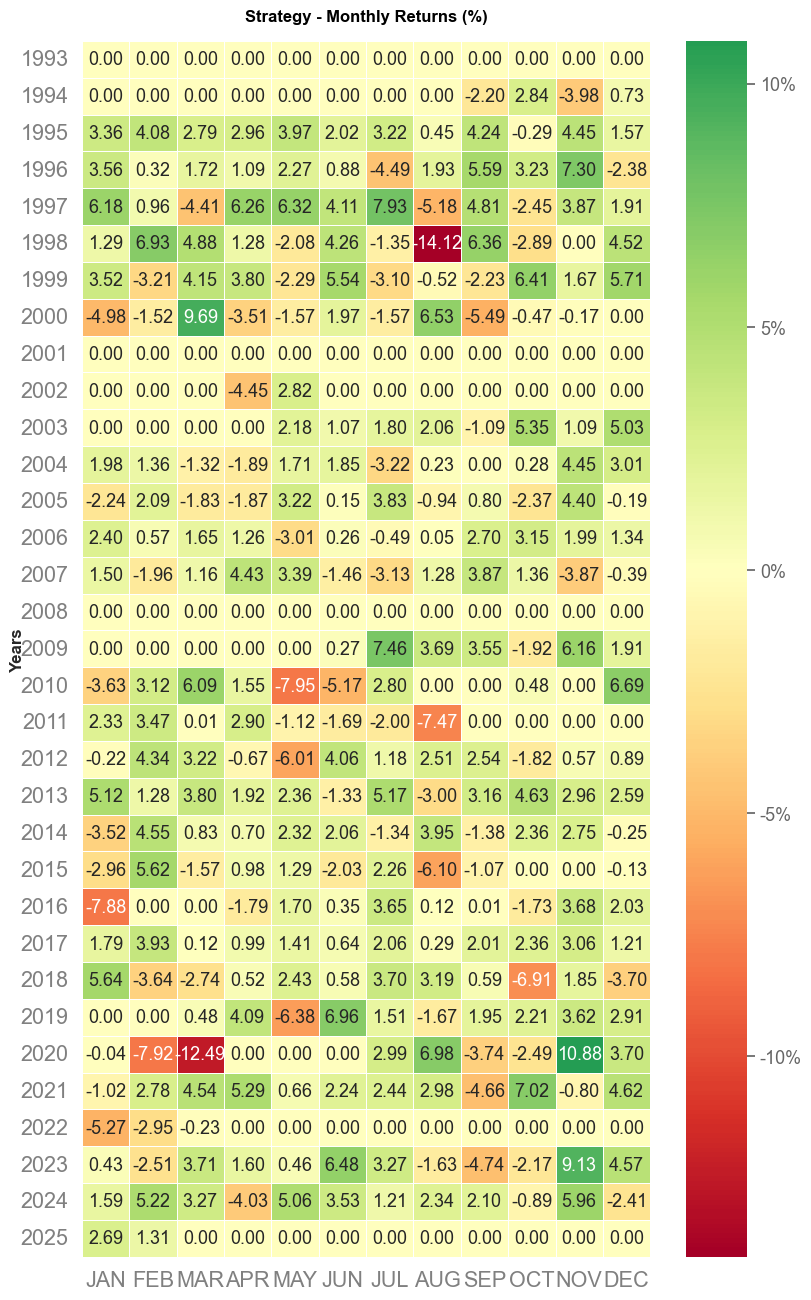

In [ ]:
#%%

qs.plots.monthly_heatmap(report_df['unrealized_ret'])

In [ ]:
#%%

print(f"Sharpe Ratio : {round(float(qs.stats.sharpe(report_df['unrealized_ret'])),2)}")

Sharpe Ratio : 0.79
